In [153]:
import random
import time
from concurrent.futures import ThreadPoolExecutor
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np


In [154]:
class Task:
    def __init__(self, name, service_time, arrival_time):
        self.name = name
        self.service_time = random.expovariate(1 / service_time)
        self.priority = self.generate_priority()
        self.arrival_time = time.time()
        self.finish_time = time.time()
        
    def generate_priority(self):
        r = random.random()
        if r <= 0.2:
            return 'high'
        elif r <= 0.5:
            return 'medium'
        else:
            return 'low'

    def __lt__(self, other):
        return self.service_time < other.service_time


In [155]:
T = 30  # 10 seconds of simulation time
k = 3  # 3 servers
lambda_param = 5  # Poisson distribution parameter
max_queue_size = 10  # Maximum queue size for each server
policy = 'weighted_round_robin'  # Choose from 'fifo', 'weighted_round_robin', or 'non_preemptive_priority'

In [156]:
def task_generator(T, lambda_param, start_time):
    current_time = start_time
    task_count = 0
    while current_time < T + start_time:
        task_count += 1
        inter_arrival_time = random.expovariate(lambda_param)
        current_time += inter_arrival_time
        yield Task(f"Task {task_count}", inter_arrival_time, time.time())


In [157]:
def process_task(queue, policy):
    if policy == 'fifo':
        task = fifo_policy(queue)
    elif policy == 'weighted_round_robin':
        task = weighted_round_robin_policy(queue)
    elif policy == 'non_preemptive_priority':
        task = non_preemptive_priority_policy(queue)
    else:
        raise ValueError(f"Unknown policy: {policy}")

    if task:
        time_in_queue = time.time() - task.arrival_time
        task.finish_time = time.time()
        time.sleep(task.service_time)
        # print(f"{task.name} with priority {task.priority} is processed")
        if task.priority == 'high':
            return time_in_queue
        else:
            return None


In [158]:
def fifo_policy(queue):
    return queue.get()

def weighted_round_robin_policy(queue):
    high_priority = [task for task in queue.queue if task.priority == 'high']
    medium_priority = [task for task in queue.queue if task.priority == 'medium']
    low_priority = [task for task in queue.queue if task.priority == 'low']
    if high_priority:
        return high_priority.pop(0)
    elif medium_priority:
        return medium_priority.pop(0)
    elif low_priority:
        return low_priority.pop(0)
    else:
        return None

def non_preemptive_priority_policy(queue):
    sorted_tasks = sorted(queue.queue, key=lambda task: task.priority)
    task = sorted_tasks.pop(0)
    queue.queue.remove(task)
    return task


In [159]:
def run_simulation(T, k, lambda_param, max_queue_size, policy):
    if policy == 'weighted_round_robin':
        task_queues = [{'high': PriorityQueue(maxsize=max_queue_size), 
                        'medium': PriorityQueue(maxsize=max_queue_size), 
                        'low': PriorityQueue(maxsize=max_queue_size)} for _ in range(k)]
    else:
        task_queues = [PriorityQueue(maxsize=max_queue_size) for _ in range(k)]
    dropped_tasks = 0
    total_tasks = 0
    total_queue_sizes = [0] * k
    total_task_times = [0] * k
    server_busy_times = [0] * k
    task_arrival_times = []

    start_time = time.time()
    active_tasks = []
    with ThreadPoolExecutor(max_workers=k) as executor:
        for task in task_generator(T, lambda_param,start_time):
            total_tasks += 1
            task_arrival_times.append((total_tasks, time.time() - start_time))
            if policy == 'weighted_round_robin':
                min_queue = min(task_queues, key=lambda q: q[task.priority].qsize())
                if min_queue[task.priority].full():
                    dropped_tasks += 1
                else:
                    active_tasks.append(task)
                    min_queue_idx = task_queues.index(min_queue)
                    total_queue_sizes[min_queue_idx] += 1
                    total_task_times[min_queue_idx] += task.service_time
                    server_busy_times[min_queue_idx] += task.service_time
                    min_queue[task.priority].put(task)
                    time_in_queue = executor.submit(process_task, min_queue[task.priority], policy).result()
            else:
                min_queue = min(task_queues, key=lambda q: q.qsize())
                if min_queue.full():
                    dropped_tasks += 1
                else:
                    active_tasks.append(task)
                    min_queue_idx = task_queues.index(min_queue)
                    total_queue_sizes[min_queue_idx] += 1
                    total_task_times[min_queue_idx] += task.service_time
                    server_busy_times[min_queue_idx] += task.service_time
                    min_queue.put(task)
                    time_in_queue = executor.submit(process_task, min_queue, policy).result()
                    if task.priority == 'high':
                        high_priority_times.append(task.finish_time - task.arrival_time)
    cook = []
    for task in active_tasks :
        if task.priority == 'high' :
            # print(task.finish_time - task.arrival_time) 
            cook.append((task.finish_time - task.arrival_time)*1000)
    avg_queue_sizes = [size / total_tasks for size in total_queue_sizes]
    avg_time_spent_queues = [task_time / total_tasks for task_time in total_task_times]
    avg_server_utilization = [busy_time / T for busy_time in server_busy_times]

    return dropped_tasks, total_tasks, avg_queue_sizes, avg_time_spent_queues, avg_server_utilization, cook


In [160]:
dropped_tasks, total_tasks, avg_queue_sizes, avg_time_spent_queues, avg_server_utilization,high_priority_times = run_simulation(T, k, lambda_param, max_queue_size, policy)
print(f"Total tasks generated: {total_tasks}")
print(f"Dropped tasks: {dropped_tasks}")
print(f"Average queue sizes: {avg_queue_sizes}")
print(f"Average time spent in all queues: {sum(avg_time_spent_queues) / len(avg_time_spent_queues)}")
print(f"Average time spent in each queue: {avg_time_spent_queues}")
print(f"Average server utilization: {avg_server_utilization}")


Total tasks generated: 174
Dropped tasks: 84
Average queue sizes: [0.1724137931034483, 0.1724137931034483, 0.1724137931034483]
Average time spent in all queues: 0.03307248406181081
Average time spent in each queue: [0.025094659375237697, 0.030089233045296915, 0.04403355976489783]
Average server utilization: [0.14554902437637865, 0.1745175516627221, 0.25539464663640743]


In [161]:
scheduling_policies = ['fifo', 'weighted_round_robin', 'non_preemptive_priority']
high_priority_times_by_policy = {}
for policy in scheduling_policies:
    np.random.seed(None)  # Add this line
    dropped_tasks, total_tasks, avg_queue_sizes, avg_time_spent_queues, avg_server_utilization,high_priority_times = run_simulation(T, k, lambda_param, max_queue_size, policy)
    print(high_priority_times)
    high_priority_times_by_policy[policy] = high_priority_times

[0.5364418029785156, 0.2162456512451172, 0.21648406982421875, 0.23746490478515625, 0.2269744873046875, 0.23102760314941406, 0.19931793212890625, 0.21076202392578125, 0.2281665802001953, 0.19979476928710938, 0.1957416534423828, 0.23365020751953125, 0.22268295288085938, 0.24199485778808594, 0.23412704467773438, 0.23412704467773438, 0.25963783264160156, 0.2319812774658203, 0.2315044403076172, 0.2617835998535156, 0.2028942108154297, 0.2200603485107422, 0.217437744140625, 0.23555755615234375, 0.27489662170410156, 0.2238750457763672, 0.0858306884765625, 0.2300739288330078, 0.23436546325683594, 0.2307891845703125, 0.232696533203125]
[0.29659271240234375, 0.22912025451660156, 847.6850986480713, 728.3883094787598, 252.62808799743652, 0.0007152557373046875, 0.000476837158203125, 0.0007152557373046875, 274.003267288208, 0.0007152557373046875, 0.000476837158203125, 0.0007152557373046875, 0.0011920928955078125, 0.25582313537597656, 0.0007152557373046875, 72.86286354064941, 76.72858238220215, 76.862

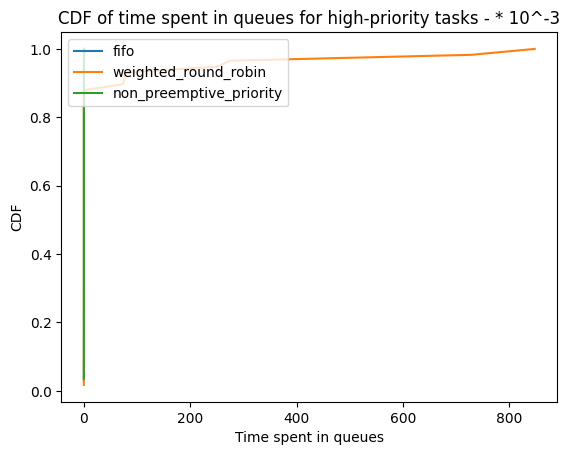

In [162]:
for policy, high_priority_times in high_priority_times_by_policy.items():
    sorted_times = np.sort(high_priority_times)
    yvals = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    plt.plot(sorted_times, yvals, label=policy)

plt.xlabel('Time spent in queues')
plt.ylabel('CDF')
plt.legend(loc='upper left')
plt.title('CDF of time spent in queues for high-priority tasks - * 10^-3')
plt.show()